# Task -1 Anomaly detection
## Student ID1: 207276775
GitHub project: https://github.com/RazElbaz/Task-1-Anomaly-detection
(GitHub also has the Docker application with UI section)

In [1]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
# data wrangling
from sklearn.cluster import DBSCAN

## Read the data
In this section we will read the information we received from the file for which we will need to perform anomaly detection

In [2]:
f_path = "/Users/97252/Downloads/conn_attack.csv"
'''
record ID - The unique identifier for each connection record.
duration_  This feature denotes the number of seconds (rounded) of the connection. For example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
src_bytes This field represents the number of data bytes transferred from the source to the destination (i.e., the amount of out-going bytes from the host).
dst_bytes This fea
ture represents the number of data bytes transferred from the destination to the source (i.e., the amount of bytes received by the host).
'''
df = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None)
df

,record ID,duration_,src_bytes,dst_bytes
0,1,0,236,1228
1,2,0,239,486
2,3,0,234,1364
3,4,0,239,1295
4,5,0,181,5450
...,...,...,...,...
256665,256666,0,306,236
256666,256667,0,288,4017
256667,256668,0,289,1096
256668,256669,0,198,2169


# # Pandas DataFrame


A. Handling missing data

In [3]:
# determin the missing data precentage
df.apply(lambda x: sum(x.isna()) / len(df))

record ID    0.0
duration_    0.0
src_bytes    0.0
dst_bytes    0.0
dtype: float64

B. Remove na/nan: ##The Pandas function dropna() drops rows or columns (depending on the parameter you choose) that contain missing values. This function takes the axis parameter which you set as 0 to drop rows, and 1 to drop columns.

In [4]:
df.shape


(256670, 4)

In [5]:
df.isnull().any().any() # check if we have nan values.

False

E. Describe

In [6]:
#Mean
df['dst_bytes'].mean()

4473.532613862158

In [7]:
#Median of two seperate columns
df[["src_bytes", "dst_bytes"]].median()

src_bytes     249.0
dst_bytes    1661.0
dtype: float64

In [8]:
#Instead of the predefined statistics, specific combinations can be calculated
df.agg(
    {
        "duration_": ["min", "max", "median", "skew"],
        "dst_bytes": ["min", "max", "median", "mean"],
    }
)

,duration_,dst_bytes
min,0.000000,0.000000e+00
max,3289.000000,7.068759e+06
median,0.000000,1.661000e+03
skew,74.033196,NaN
mean,NaN,4.473533e+03


# Data exploration
### Explore the data, understand the featues, statistics visualize the inputs

### What is Data Exploration?
Data exploration definition: Data exploration refers to the initial step in data analysis in which data analysts use data visualization and statistical techniques to describe dataset characterizations, such as size, quantity, and accuracy, in order to better understand the nature of the data.

https://www.heavy.ai/learn/data-exploration 
### Why Is Data Exploration Important? 
Exploration allows for deeper understanding of a dataset, making it easier to navigate and use the data later. The better an analyst knows the data they're working with, the better their analysis will be.

https://www.alteryx.com/glossary/data-exploration

skew:
    
    In probability theory and statistics, skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. The skewness value can be positive, zero, negative, or undefined.


In [9]:
'''
Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.
'''
#skewness and kurtosis
print("Skewness: %f" % df['src_bytes'].skew())
print("Kurtosis: %f" % df['src_bytes'].kurt()) # positive show long tail , negative light tail

Skewness: 15.824471
Kurtosis: 248.739606


C:\Users\97252\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 207.100418
Kurtosis: 61028.785029


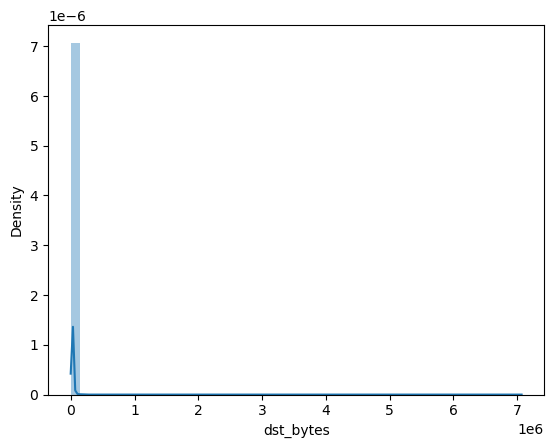

In [10]:
sns.distplot(df['dst_bytes'])
print("Skewness: %f" % df['dst_bytes'].skew())
print("Kurtosis: %f" % df['dst_bytes'].kurt())

C:\Users\97252\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 74.033196
Kurtosis: 11208.320742


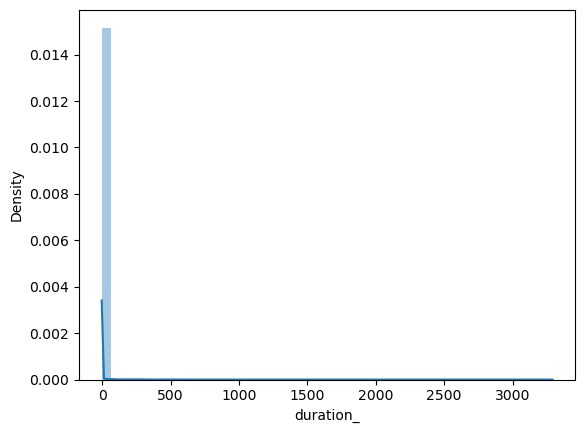

In [11]:
sns.distplot(df['duration_'])
print("Skewness: %f" % df['duration_'].skew())
print("Kurtosis: %f" % df['duration_'].kurt())

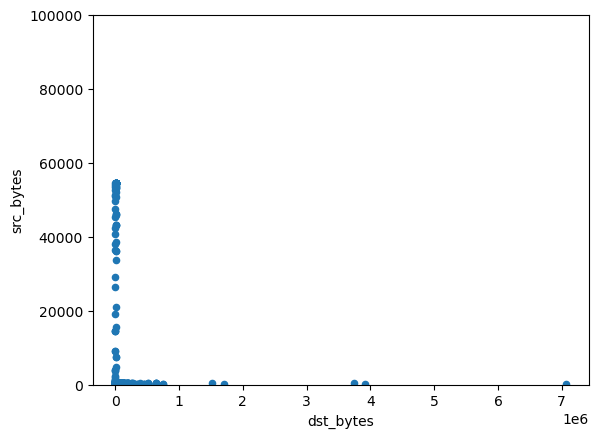

In [12]:
#Relationship with numerical variables
var = 'dst_bytes'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,100000)); # do not `assume here any thing this is just examples

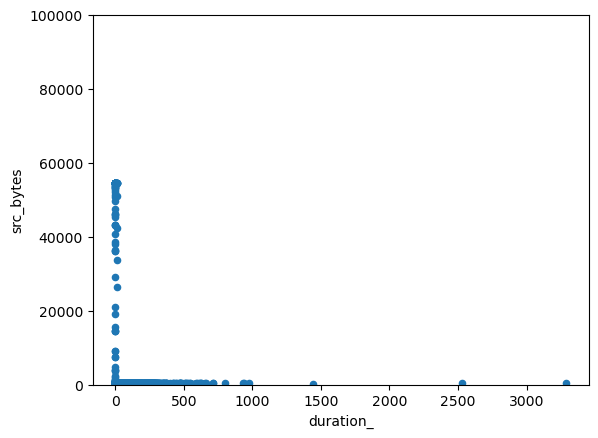

In [13]:
#scatter plot totalbsmtsf/saleprice
var = 'duration_'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,100000));

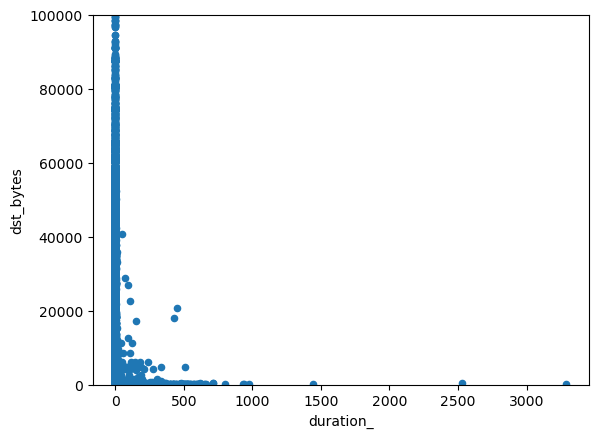

In [14]:
#scatter plot totalbsmtsf/saleprice
var = 'duration_'
data = pd.concat([df['dst_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='dst_bytes', ylim=(0,100000));

In [15]:
df.corr() 

,record ID,duration_,src_bytes,dst_bytes
record ID,1.000000,0.027244,0.019209,-0.002970
duration_,0.027244,1.000000,-0.001714,-0.005791
src_bytes,0.019209,-0.001714,1.000000,0.010770
dst_bytes,-0.002970,-0.005791,0.010770,1.000000


## Memory Heat Map (MHM)
According to the article:
http://www.cs.yale.edu/homes/yoon-man-ki/DAC2015_MemoryHeatMap.pdf ,
The efficiency can be seen in the Memory Heat Map (MHM) to characterize the memory behavior of the operating system and to identify an anomaly in a real-time system.

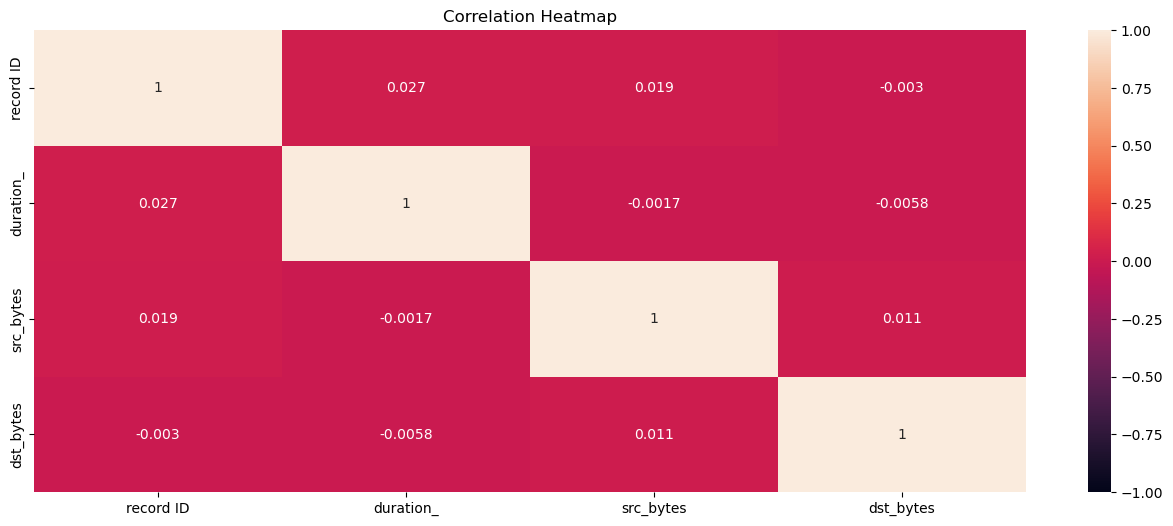

In [16]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

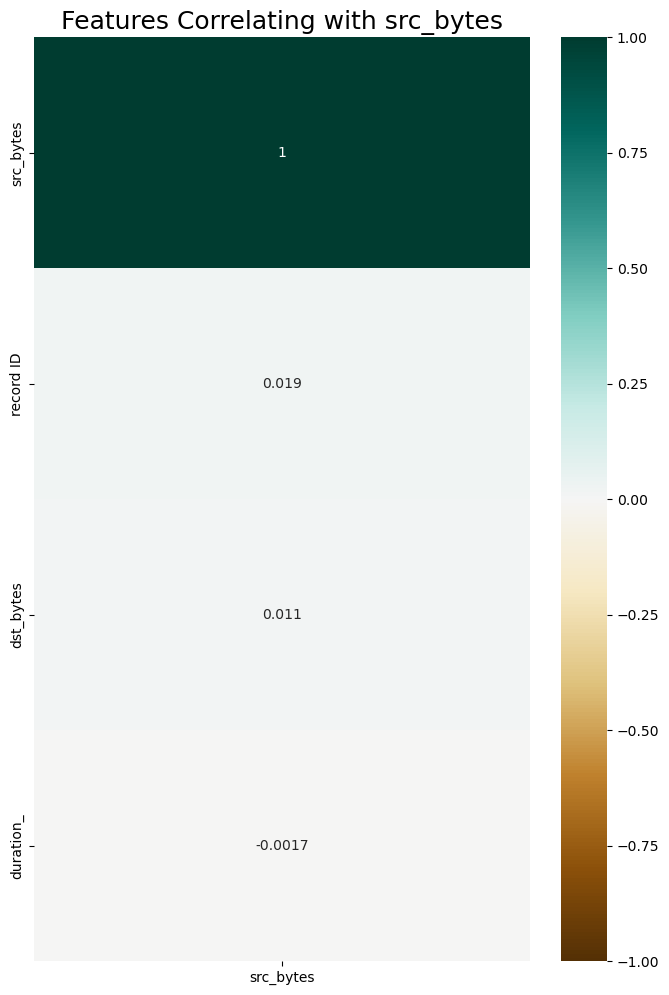

In [17]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['src_bytes']].sort_values(by='src_bytes', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with src_bytes', fontdict={'fontsize':18});

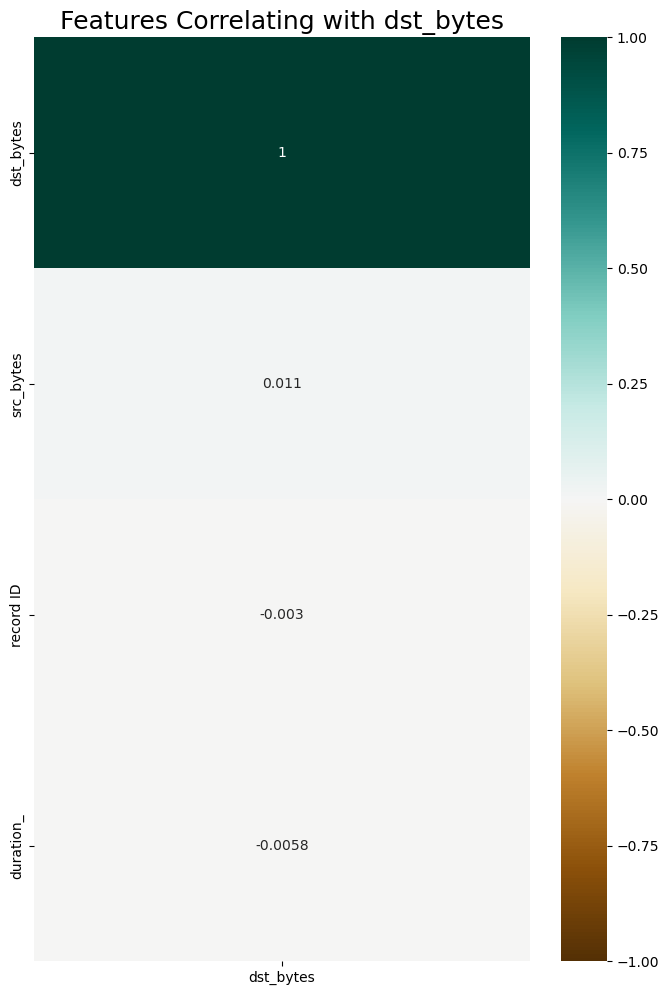

In [18]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['dst_bytes']].sort_values(by='dst_bytes', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with dst_bytes', fontdict={'fontsize':18});

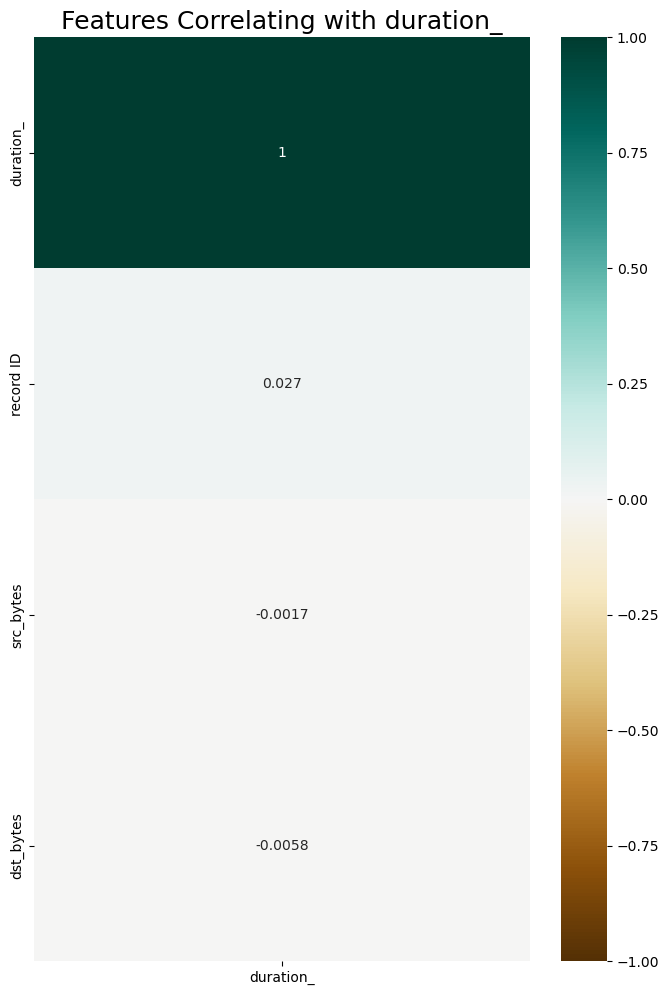

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['duration_']].sort_values(by='duration_', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with duration_', fontdict={'fontsize':18});

# Machine Learning Algorithm

## Anomaly detection using Isolation Forest

(Definition from the presentation of lecture 3): 
### Isolation Forest
* Choosing a record within the dataset and its variables;
* Choosing a random value within the minimum and maximum of each variable or from uniform distribution;
* Creating a node or branch: if the value of the record under consideration is greater or less than the previous random value, we repeat the exercise of evaluating our point with the minimum and maximum interval, limiting it further this time, with the cut-off point being the new maximum or minimum of the branch created.
* Executing the third step until further branching is not possible and the point to be evaluated is isolated.
* Thus, the fewer branches needed by the tree to isolate the point, the more
anomalous it will be

To better understand the material, I also watched the following video: https://www.youtube.com/watch?v=cRzeotaFDwk&ab_channel=MachineLearningInterview

### Theory
The main idea, which is different from other popular outlier detection methods, is that Isolation Forest explicitly identifies anomalies instead of profiling normal data points. Isolation Forest, like any tree ensemble method, is built on the basis of decision trees. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.
As with other outlier detection methods, an anomaly score is required for decision making. In the case of Isolation Forest, it is defined as:

## $$s(x,n)=2^\frac{-E(h(x))}{c(n)} $$

*h(x) is the path length of observation x

*c(n) is the average path length of unsuccessful search in a Binary Search Tree

*n is the number of external nodes

https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

### Isolation Forest Algorithm.

Return the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

# Code 

After presenting the selected Isolation Forest algorithm, I will divide my answer into experiments (part one), show the results of the experiments for the selected parameters (part two) and after finding the best result I will show the graphs for them (part three).

# First part: experiments
#### Studying the algorithm and choosing the appropriate parameters

class sklearn.ensemble.IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)
* n_estimatorsint, default=100 -> The number of base estimators in the ensemble.
* contamination ‘auto’ or float, default=’auto’-> The amount of contamination of the data set
* max_featuresint or float, default=1.0-> The number of features to draw from X to train each base estimator
* bootstrapbool, default=False -> If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is performed.
* n_jobsint, default=None -> The number of jobs to run in parallel for both fit and predict.
* random_stateint, RandomState instance or None, default=None -> Controls the pseudo-randomness of the selection of the feature and split values for each branching step and each tree in the forest.
* random_stateint, RandomState instance or None, default=None -> random_stateint, RandomState instance or None, default=None
* verboseint, default=0 -> Controls the verbosity of the tree building process.
* warm_startbool, default=False -> When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. 

I researched and saw that most of the parameters are usually set to "default" values with the exception of the following parameters:
* n_estimatorsint
* contamination

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
#We learned in lecture 2 that for the generated data set, the first n-1 columns
#constitute the input attributes and thelast one constitutes the target attributes(label)
input_attributes=df[["duration_", "src_bytes","dst_bytes"]]

### Experiments for the n_estimators parameter:

In [21]:
n_estimators=50
for x in range(10):
    isolation_forest = IsolationForest(n_estimators=n_estimators+(100*x))
    isolation_forest.fit(input_attributes.values)
    df["anomaly"] = pd.Series(isolation_forest.predict(input_attributes.values))
    df["anomaly"] = df["anomaly"].map({1:0, -1:1})
    print("---------------------------")
    print("For n_estimators=", n_estimators+(100*x))
    print(df["anomaly"].value_counts())


---------------------------
For n_estimators= 50
0    233874
1     22796
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 150
0    235445
1     21225
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 250
0    231758
1     24912
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 350
0    235118
1     21552
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 450
0    232477
1     24193
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 550
0    233804
1     22866
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 650
0    233970
1     22700
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 750
0    234037
1     22633
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 850
0    235039
1     21631
Name: anomaly, dtype: int64
---------------------------
For n_estimators= 950
0    233717
1     22953
Name: ano

### Experiments for the contamination parameter: 
0.05 reduction in each iteration

In [22]:
contamination=0.5 # contamination should be in the range (0, 0.5]
for x in range(10):
    isolation_forest = IsolationForest(contamination=contamination-(0.05*x),n_estimators=100)
    isolation_forest.fit(input_attributes.values)
    df["anomaly"] = pd.Series(isolation_forest.predict(input_attributes.values))
    df["anomaly"] = df["anomaly"].map({1:0, -1:1})
    print("---------------------------")
    print("For contamination=", contamination-(0.05*x))
    print(df["anomaly"].value_counts())

---------------------------
For contamination= 0.5
0    128337
1    128333
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.45
0    141174
1    115496
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.4
0    154003
1    102667
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.35
0    166837
1     89833
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.3
0    179669
1     77001
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.25
0    192502
1     64168
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.19999999999999996
0    205336
1     51334
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.14999999999999997
0    218170
1     38500
Name: anomaly, dtype: int64
---------------------------
For contamination= 0.09999999999999998
0    231004
1     25666
Name: anomaly, dtype: int64
----------------------

# Part Two: The conclusions of the experiments
#### Experimental conclusions for the n_estimators parameter:
The number of selected iterations is 10 (chosen randomly).
The changes are very minor even when we look at the differences between giving a value of 50 to the parameter and giving a value of 950. Therefore we choose the base value for the parameter: 100
#### Experimental conclusions for the contamination parameter:
The number of selected iterations is 10 (chosen randomly).
The changes are very significant for each change, even for the small value reductions I chose (I reduced 0.05  each iteration). Therefore we will choose the value obtained in the last experiment and it is 0.05.


# Third part: Displaying the graphs for data exploration
The selected algorithm parameters (after the experiment presented above):
##### contamination=0.05
##### n_estimators=100 (the default value) 

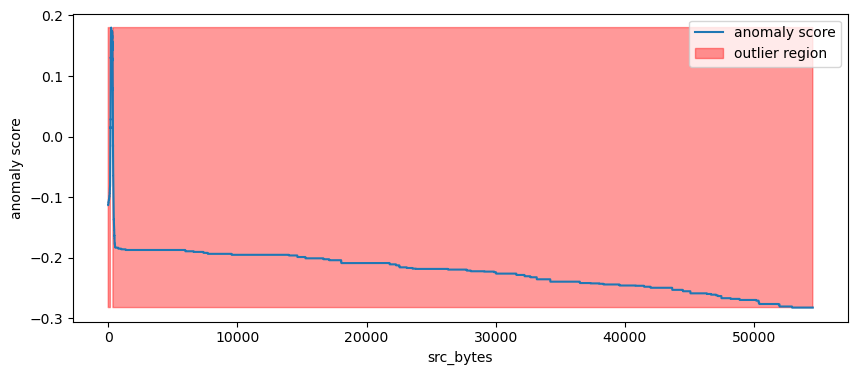

In [23]:
from sklearn.ensemble import IsolationForest
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
isolation_forest = IsolationForest(contamination=0.05, n_estimators=100)
#fit(X, y=None, sample_weight=None)[source]: Fit estimator
#reshape: The function flattens a nested array of an unknown number of elements into a 1D array
isolation_forest.fit(df['src_bytes'].values.reshape(-1, 1))
#The NumPy linspace function (sometimes called np. linspace) is a tool in Python for creating numeric sequences.
xx = np.linspace(df['src_bytes'].min(), df['src_bytes'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
#predict() : given a trained model, predict the label of a new set of data. This method accepts one argument, the new data X_new (e.g. model. predict(X_new) ), and returns the learned label for each object in the array
outlier = isolation_forest.predict(xx)
#figsize is a tuple of the width and height of the figure in inches
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('src_bytes')
plt.show();

#https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb

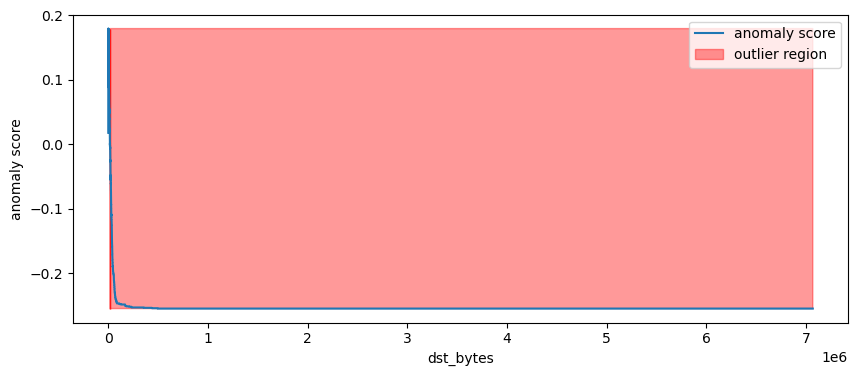

In [24]:
from sklearn.ensemble import IsolationForest
#n_estimatorsint, default=100: The number of base estimators in the ensemble.
isolation_forest = IsolationForest(contamination=0.05, n_estimators=100)
#fit(X, y=None, sample_weight=None)[source]: Fit estimator
#reshape: The function flattens a nested array of an unknown number of elements into a 1D array
isolation_forest.fit(df['dst_bytes'].values.reshape(-1, 1))
#The NumPy linspace function (sometimes called np. linspace) is a tool in Python for creating numeric sequences.
xx = np.linspace(df['dst_bytes'].min(), df['dst_bytes'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
#predict() : given a trained model, predict the label of a new set of data. This method accepts one argument, the new data X_new (e.g. model. predict(X_new) ), and returns the learned label for each object in the array
outlier = isolation_forest.predict(xx)
#figsize is a tuple of the width and height of the figure in inches
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('dst_bytes')
plt.show();

In [25]:
metrics_df=pd.pivot_table(df,values='dst_bytes',index='record ID',columns='src_bytes')
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df

src_bytes,record ID,0,51,137,138,139,140,141,142,143,...,51100,51180,51992,52560,53168,53208,53452,53776,54060,54540
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256665,256666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256666,256667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256667,256668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256668,256669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


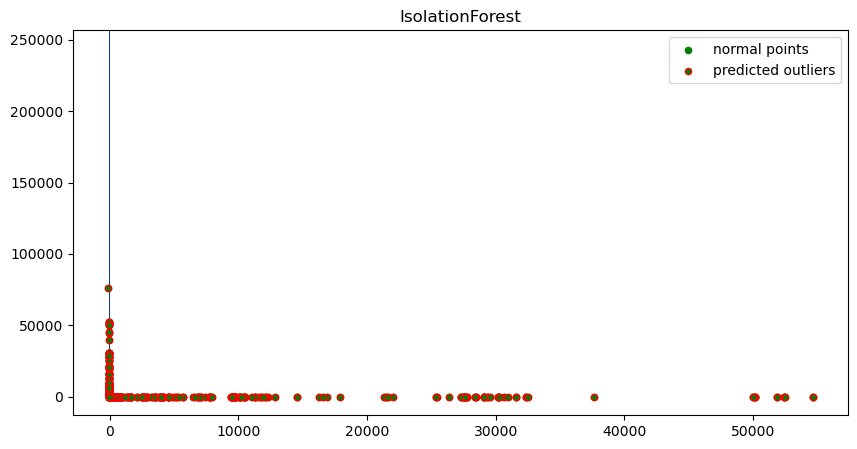

In [26]:
from sklearn.decomposition import PCA
metrics_df.columns
to_model_columns=metrics_df.columns[1:13]
clf=IsolationForest(n_estimators=100,  contamination=0.05)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
pca = PCA(2)
pca.fit(metrics_df[to_model_columns])
res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
Z = np.array(res)
# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
#https://www.geeksforgeeks.org/change-plot-size-in-matplotlib-python/

## Accuracy:
Accuracy tells us how often is the classifier correct?

###### Accuracy = ( TP + TN ) / ( TP + TN + FP + FN )

True Positive (TP) : Observation is positive, and is predicted to be positive.

False Negative (FN) : Observation is positive, but is predicted negative.

True Negative (TN) : Observation is negative, and is predicted to be negative.

False Positive (FP) : Observation is negative, but is predicted positive.

##### i used sklearn - Accuracy which calculates this
______________________________________________________________________________________________________________________________
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html https://medium.com/analytics-vidhya/classification-and-its-performance-metrics-in-machine-learning-f0ad57866ec9

In [27]:
#We learned in lecture 2 that for the generated data set, the first n-1 columns
#constitute the input attributes and thelast one constitutes the target attributes(label)
input_attributes=df[["duration_", "src_bytes","dst_bytes"]]

In [28]:
isolation_forest.fit(input_attributes.values)

IsolationForest(contamination=0.05)

In [29]:
df["anomaly"] = pd.Series(isolation_forest.predict(input_attributes.values))
df["anomaly"] = df["anomaly"].map({1:0, -1:1})
print(df["anomaly"].value_counts())

0    243837
1     12833
Name: anomaly, dtype: int64


The truth results of the labels whether the point is an anomaly:

In [30]:
f_path ="/Users/97252/Downloads/conn_attack_anomaly_labels.csv"
df_true = pd.read_csv(f_path,names=["record ID","anomaly"], header=None)
print(df_true["anomaly"].value_counts())

0    255648
1      1022
Name: anomaly, dtype: int64


In [31]:
accuracy = accuracy_score(df_true["anomaly"], df["anomaly"])
#The printing is according to the section Introduction to ML in python given to us
print("Accuracy score: {0:.2f}%".format(accuracy*100))

Accuracy score: 95.40%


In [32]:
accuracy_score(df_true["anomaly"], df["anomaly"], normalize=False) #The number of points where the prediction and the truth

244855

## Recall
Recall gives us an idea about when it’s actually yes, how often does it predict yes.
The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

i used sklearn - recall

In [33]:
from sklearn.metrics import recall_score
recall = recall_score(df_true["anomaly"], df["anomaly"])
print("Recall score: {0:.2f}%".format(recall*100))

Recall score: 99.80%


## Confusion matrix
In technical terms: A confusion matrix is a performance measurement technique for Machine learning classification. It is a kind of table which helps you to know the performance of the classification model on a set of test data for that the true values are known.

sklearn - confusion matrix

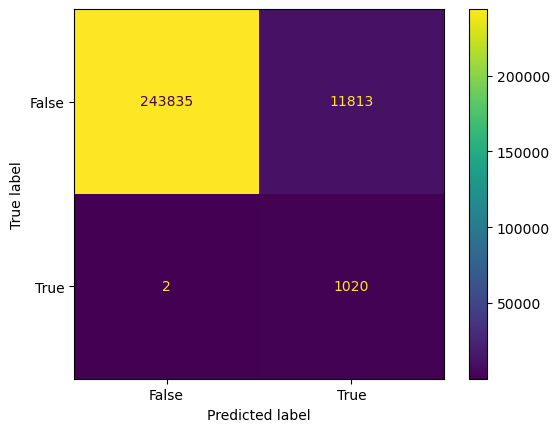

In [34]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(df_true["anomaly"], df["anomaly"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


# Summary of the results
I came to a result of 95.40% after researching and testing what I think is the best algorithm for solving the problem and it is - Isolation Forest. This method works differently from many algorithms whose results I have seen. It explicitly isolates outliers instead of profiling and constructing normal points and regions by assigning a score to each data point. This takes advantage of the fact that outliers are the minority data points and have very different feature values ​​than normal cases. This algorithm works great with very high dimensional data sets (like we got in this task) and it has proven to be a very effective way to detect anomalies. Although the purpose of the assignment is to focus on application rather than knowledge, I saw fit to expand my entire learning process on the algorithm. I presented to you the experiments and results I did in order to reach a high percentage in finding abnormal points: I looked for the parameters that I should change in order to achieve good anomaly detection results, I saw that most of the parameters are "none", so I preferred not to change them. Also, I saw parameters that were not relevant to me, so there was no need to change their default value - false. That's why I accessed 2 relevant parameters: n_estimatorsint, contamination and applied the changes to them. At first I made changes to the n_estimatorsint parameter, I saw that even very large changes did not affect it so I left it with a value of 100. After that, I made changes to the contamination parameter. At the beginning I saw that the amount of anomalous points with the initial parameter contamination= 0.5 was almost 50%, which in my opinion would not have seemed logical so I randomly chose to perform 10 iterations in which in each iteration I subtracted 0.05 from the variable - all this based on the fact that the range of contamination values should be in the range (0, 0.5). I came to the conclusion that the amount of random points was 5% of the total amount of points, which seemed to me a reasonable percentage.

# Answers to the questions and how and why the team selected to solve this problem in this way.
Questions:
1. Data exploration- what have you learned? 
2. Which algorithms group is suitable for this task and why?
3. Please create a report that will explain how you solved the problem.
a. What is the approach you tried? Why them?
b. How do you know the algorithm is good?
4. What is the accuracy and recall of the algorithm the team developed?
Show the confusion matrix. Will be ranked based on the results of the entire class 
5. User anomaly detection UI based on Docker implementation.

Answers:
### Answer to question number 1:
Data exploration definition: Data exploration refers to the initial step in data analysis in which data analysts use data visualization and statistical techniques to describe dataset characterizations, such as size, quantity, and accuracy, in order to better understand the nature of the data.

Data exploration is the first step of data analysis used to explore and visualize data to uncover the data in the first place or identify areas or patterns worth digging into further.
Data exploration is usually carried out in three stages:
Understand the variables, identifying anomalies and examining patterns and relationships.
 The foundation of any data analysis begins with understanding variables. A quick read of the column names is a good place to start. That's why I read the definitions of the columns (of the variables in the data set), I understood what each represents and the relationship between them. 
Outliers or anomalies can destroy an analysis and distort the reality of a data set, and it is important to identify them at an early stage. That's why I checked the skewness and kurtosis of each of the variables, I activated the corr() function - correlation is a statistical term that in common use refers to how close two variables are to having a linear relationship with each other. In addition I visually presented graphs representing the relationship between the variables and presented graphs of features that correlate with the variables.

Exploring the data helped me understand the relationship between the variables in the dataset - "record id","duration_", "src_bytes","dst_bytes". After understanding the role of each variable and the relationship between them, I used these points to find outliers in the samples and to find outliers in the data.
The investigation allowed me a deeper understanding of a dataset, making it easier to navigate and use the data later. The better an analyst knows the data he is working with, the better his analysis will be.

### Answer to question number 2:
* ###### Standard Deviation:
Standard deviation is a number that describes how spread out the values are.
A low standard deviation means that most of the numbers are close to the mean (average) value.
A high standard deviation means that the values are spread out over a wider range.
Example: The speed of 7 cars:
speed = [86,87,88,86,87,85,86]
The standard deviation is: 0.9

    This algorithm can be good for the task because :
    The amount of data that is clustered around a mean value is shown.
    It provides a more precise picture of how data is disseminated.
    Extreme values have less of an impact.
* ###### Boxplots:
Box plots are a graphical depiction of numerical data through their quantiles. It is a very simple but effective way to visualize outliers. Think about the lower and upper whiskers as the boundaries of the data distribution. Any data points that show above or below the whiskers, can be considered outliers or anomalous. 

    This algorithm can be good for the task because Boxplots have the following strengths: Graphically display a variable's location and spread at a glance. Provide some indication of the data's symmetry and skewness. Unlike many other methods of data display, boxplots show outliers.

* ###### DBScan Clustering:
DBScan is a clustering algorithm that’s used cluster data into groups. It is also used as a density-based anomaly detection method with either single or multi-dimensional data : given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). 

    This algorithm can be good for the task because:
    * Can look out for outliers (major)
    * No need for a numClasses parameter
    * Ability to identify uneven shapes
    * It is easy for someone who knows the dataset, to set the parameters

* ###### Isolation Forest:
Isolation Forest is an unsupervised learning algorithm that belongs to the ensemble decision trees family. This approach is different from all previous methods. All the previous ones were trying to find the normal region of the data then identifies anything outside of this defined region to be an outlier or anomalous.
IsolationForests were built based on the fact that anomalies are the data points that are “few and different”. 
This method works differently. It explicitly isolates anomalies instead of profiling and constructing normal points and regions by assigning a score to each data point. It takes advantage of the fact that anomalies are the minority data points and that they have attribute-values that are very different from those of normal instances.

    This algorithm can be good for the task because it  works great with very high dimensional datasets and it proved to be a very effective way of detecting anomalies. In addtion reduced computational times as anomalies are identified early and quick. 

* ###### Robust Random Pruning Forest:
The Random Cut Forest (RCF) algorithm is Amazon's unsupervised anomaly detection algorithm. It also works by assigning an anomaly score. Low score values​indicate that the data point is considered "normal". High values​indicate the presence of an anomaly in the data. The definitions of "low" and "high" are application dependent, but common practice indicates that scores beyond three standard deviations from the mean score are considered anomalous.

    This algorithm can be good for the task because it can perform both regression and classification tasks. A random forest produces good predictions that can be understood easily. It can handle large datasets efficiently. The random forest algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm.
    
### Answer to question number 3:
### a:
The approach I tried is to understand all the parts of the problem in depth, study them and from them develop the use of the algorithm to achieve the best results.
First I started by searching for definitions that came up in the context of the assignment such as: data explorationc, what are anomalous points, Accuracy, etc.
Second, I looked for ways to identify anomalous points - I read about different algorithms, watched videos, read articles and watched blogs on the subject.
Finally, I chose the agorithm with which I wanted to solve the Isolation Forest task. I read about its many advantages:

*Isolation Forest Advantages and Unique Points*
1) A big advantage of this algorithm compared to other methods is that it does not use distance, similarity or density measurements of the dataset, which is usually very expensive computationally. Complexity of the Isolation Forest grows linearly thanks to the benefits of sub-sampling: it computes trees by sub-parts of the dataset. Thus, it is able to scale in large datasets and with many irrelevant variable

2) Capacity to scale up to handle extremely large data size and high-dimensional problems with a large number of irrelevant attributes.

3) isolation forest detects anomalies faster than other anomaly detection algorithms. It does not calculate either distance or density and therefore significantly reduces execution time
and memory requirement.

4) Robust to the presence of outliers in training data.

5) Robust to multi-modal distributions.

6) Insensitive to the scales of variables.

7) Much faster to fit.

I read about his main idea: Isolation Forest were built based on the fact that anomalies are the data points that are “few and different”. The main idea is that Isolation Forest explicitly identifies anomalies instead of profiling normal data points.   Isolation Forest is built on the basis of decision trees. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature. In principle, outliers are less frequent than regular observations and are different from them in terms of values ​​(they lie further away from the regular observations in the feature space).

I checked which parameters the algorithm accepts, what is the role of each parameter and what is its default value (can be read in the Code section - The answer to part 1 of the assignment: Data exploration under First part: experiment and wonder).
After understanding the parameters, I looked for which parameters might be relevant because they are not defined as none\false and I found the following two parameters:
 n_estimators, contamination
I made changes to their value in several experiments and wanted to find how much the change affects the detection of the anomalies

Now we will move on to explaining the implementation stages of the algorithm in the task:
I checked which parameters the algorithm accepts, what is the role of each parameter and what is its default value (can be read in the Code section - The answer to part 1 of the assignment: Data exploration under First part: experiment and wonder). After understanding the parameters, I looked for which parameters might be relevant because they are not defined as none\false and I found the following two parameters: n_estimators, contamination I made changes to their value in several experiments and wanted to find how much the change affects the detection of the anomalies.


### b:
After during the assignment I performed data exploration, and I understood the issue of finding anomalous points, I saw that changing the value of the n_estimators parameter had no effect, so I left it as defined in its default. In the changes of the value of the contamination parameter, I saw at the beginning that the detection of the anomalous points at the beginning (for the value high-0.5) was 50%, therefore I reduced its value 10 times by 0.05 in each iteration. Then I came to the detection of 5%, which seemed possible to me for the amount of anomalous points.
Finally, I used the file given to us with the correct anomalous points and I used the accuracy_score function which compares values​in the same indexes in the arrays and returns the number of indexes where the values are the same. This way I got a good result of identifying 95.40% of the correct anomalous points, so I knew the algorithm was good.

### Answer to question number 4:
###### Accuracy: (can be seen in detail in the accuracy section shown above)
Total points we received as input: 256670
The number of points we predicted as anomalies: 12834
The number of points that are really unusual: 1022
The number of points where the prediction and the truth are the same (according to the use of the accuracy_score function which compares values in the same indexes in the arrays and returns the number of indexes where the values are the same): 244854

###### Accuracy percentage: 95.40%

###### Recall score: 99.80%

###### confusion matrix (Above, under the title confusion matrix, the graph is shown)
|      | Predicted Class Yes (+1) | Predicted Class No (-1)  |
|--------------|:-----:|-----------:|
| Actual Class Yes (+1) | TP |        FN |
| Actual Class No (-1)      |  FP |          TN |

|      | Predicted Class Yes (+1) | Predicted Class No (-1)  |
|--------------|:-----:|-----------:|
| Actual Class Yes (+1) | 1020 |  2 
| Actual Class No (-1)      |  11813|     243835

### Answer to question number 5:
Will be presented separately - according to the instructions of the lecturer Dr. Ran Dubin.

______________________________________________________________________________________________________________________________

Articles and websites that I used to solve the questions:

https://cran.r-project.org/web/packages/isotree/vignettes/An_Introduction_to_Isolation_Forests.html
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest
https://hal.archives-ouvertes.fr/hal-03537102/document
https://medium.com/codex/isolation-forest-outlier-detection-simplified-5d938548bb5c
https://medium.com/analytics-vidhya/classification-and-its-performance-metrics-in-machine-learning-f0ad57866ec9

## References
Each paragraph throughout the assignment includes the link I used for that section

## Creating DataFrame to Export Pandas DataFrame to CSV
https://www.geeksforgeeks.org/saving-a-pandas-dataframe-as-a-csv/

In [35]:
r =df["record ID"]
a = df["anomaly"]

# dictionary of lists
dict = {'record ID': r, 'is_anomaly': a}
df = pd.DataFrame(dict)
print(df)
df.to_csv('results.csv',index=False)

        record ID  is_anomaly
0               1           0
1               2           0
2               3           0
3               4           0
4               5           0
...           ...         ...
256665     256666           0
256666     256667           0
256667     256668           0
256668     256669           0
256669     256670           0

[256670 rows x 2 columns]
